In [13]:
# Module imports  
from langchain_core.tools import tool  
from langchain_openai import ChatOpenAI  
from langgraph.prebuilt import create_react_agent
from langchain_core.messages import  HumanMessage, AIMessage
import math  
from dotenv import load_dotenv
import os
load_dotenv()

True

In [2]:
# LLM Setup 
model = ChatOpenAI(openai_api_key=os.getenv('OPENAI_API_KEY'), model="gpt-4o-mini-2024-07-18")

In [3]:
@tool
def hypotenuse_length(input: str) -> float:
    """Calculates the length of the hypotenuse of a right-angled triangle given the lengths of the other two sides."""
    
    # Split the input string to get the lengths of the triangle
    sides = input.split(',')
    
    # Convert the input values to floats, removing extra spaces
    a = float(sides[0].strip())
    b = float(sides[1].strip())
    
    # Square each of the values, add them together, and find the square root 
    return math.sqrt(a**2 + b**2)

In [4]:
# Create a query using natural language
query = "What is the hypotenuse length of a triangle with side lengths of 10 and 12?"

# Pass in the hypotenuse length tool and create the agent
app = create_react_agent(model, [hypotenuse_length])

In [5]:
# Invoke the agent and print the response
response = app.invoke({"messages": [("human", query)]})
print(response['messages'][-1].content)

The length of the hypotenuse of the triangle with side lengths of 10 and 12 is approximately 15.62.


In [6]:
# Create the ReAct agent
app = create_react_agent(model, [hypotenuse_length])

In [7]:
# Invoke the agent with a query and store the messages
response = app.invoke({"messages": [("human", query)]})

# Define and print the input and output messages
print({
    "user_input": query,
    "agent_output": response["messages"][-1].content
})

{'user_input': 'What is the hypotenuse length of a triangle with side lengths of 10 and 12?', 'agent_output': 'The length of the hypotenuse of a triangle with side lengths of 10 and 12 is approximately 15.62.'}


In [10]:
response["messages"]

[HumanMessage(content='What is the hypotenuse length of a triangle with side lengths of 10 and 12?', id='744b5394-b447-4c05-82ec-6c684f815c25'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_leetsXeySYHn97ghTQ5oWBa7', 'function': {'arguments': '{"input":"10,12"}', 'name': 'hypotenuse_length'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 82, 'total_tokens': 102, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0aa8d3e20b', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-c2786e26-9218-4a25-bc68-8552ca63de3f-0', tool_calls=[{'name': 'hypotenuse_length', 'args': {'input': '10,12'}, 'id': 'call_leetsXeySYHn97ghTQ5oWBa7', 'type': 'tool_call'}], usage_metadata={'input_

In [11]:
message_history = response["messages"]
new_query = "What about one with sides 12 and 14?"

In [14]:
# Invoke the app with the full message history
response = app.invoke({"messages": message_history + [("human", new_query)]})

# Extract the human and AI messages from the result
filtered_messages = [msg for msg in response["messages"] if isinstance(msg, (HumanMessage, AIMessage)) and msg.content.strip()]

In [15]:

# Pass the new query as input and print the final outputs
print({
    "user_input": new_query,
    "agent_output": [f"{msg.__class__.__name__}: {msg.content}" for msg in filtered_messages]
})

{'user_input': 'What about one with sides 12 and 14?', 'agent_output': ['HumanMessage: What is the hypotenuse length of a triangle with side lengths of 10 and 12?', 'AIMessage: The length of the hypotenuse of a triangle with side lengths of 10 and 12 is approximately 15.62.', 'HumanMessage: What about one with sides 12 and 14?', 'AIMessage: The length of the hypotenuse of a triangle with side lengths of 12 and 14 is approximately 18.44.']}


## LangGraph

In [16]:
from langchain_openai import ChatOpenAI
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [25]:
# Define the State
class State(TypedDict):
    
    # Define messages with metadata
    messages: Annotated[list, add_messages]

# Initialize StateGraph
graph_builder = StateGraph(State)

In [26]:
# Define chatbot function to respond with the model
def chatbot(state: State):
    return {"messages": [model.invoke(state["messages"])]}

# Add chatbot node to the graph
graph_builder.add_node("chatbot", chatbot)

# Define the start and end of the conversation flow
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

# Compile the graph to prepare for execution
graph = graph_builder.compile()

In [21]:
# Define a function to execute the chatbot based on user input
def stream_graph_updates(user_input: str):
    
    # Start streaming events from the graph with the user's input
    for event in graph.stream({"messages": [("user", user_input)]}):
        
        # Retrieve and print the chatbot node responses
        for item in event.values():
            print("Agent:", item["messages"])

In [27]:
# Define the user query and run the chatbot
user_query = "Who is Ada Lovelace?"
stream_graph_updates(user_query)

Agent: [AIMessage(content="Ada Lovelace, born on December 10, 1815, was an English mathematician and writer, widely recognized as one of the first computer programmers. She is best known for her work on Charles Babbage's early mechanical general-purpose computer, the Analytical Engine. Lovelace's notes on the engine, particularly her description of an algorithm intended for implementation on the machine, are considered to be the first computer program.\n\nLovelace's contributions extended beyond mere programming; she also conceptualized the idea that machines could go beyond number-crunching to perform tasks related to any form of data, including music and graphics. Her vision of computing as a means to manipulate symbols and create complex outputs laid the groundwork for the later development of modern computing.\n\nIn recognition of her pioneering work, Ada Lovelace is often celebrated as a symbol of women in technology and computing. Ada Lovelace Day, held annually on the second Tue

In [29]:
from IPython.display import  Image, display

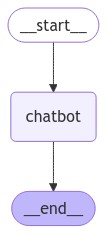

In [30]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [31]:
from langchain_community.utilities import WikipediaAPIWrapper 
from langchain_community.tools import WikipediaQueryRun    

In [33]:
# Initialize Wikipedia API wrapper to fetch top 1 result 
api_wrapper = WikipediaAPIWrapper(top_k_results=1)    
# Create a Wikipedia query tool using the API wrapper 
wikipedia_tool = WikipediaQueryRun(api_wrapper=api_wrapper)  
tools = [wikipedia_tool]

In [34]:
# Bind the Wikipedia tool to the language model
model_with_tools = model.bind_tools(tools)

# Modify chatbot function to respond with Wikipedia
def chatbot(state: State):
    return {"messages": [model_with_tools.invoke(state["messages"])]}

In [35]:
from langgraph.prebuilt import ToolNode, tools_condition

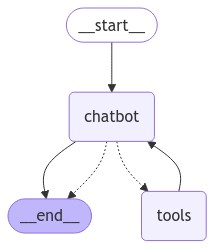

In [36]:
# Initialize StateGraph
graph_builder = StateGraph(State)
# Add chatbot node to the graph
graph_builder.add_node("chatbot", chatbot)

# Create a ToolNode to handle tool calls and add it to the graph
tool_node = ToolNode(tools=[wikipedia_tool])
graph_builder.add_node("tools", tool_node)

# Set up a condition to direct from chatbot to tool or END node
graph_builder.add_conditional_edges("chatbot", tools_condition)

# Connect tools back to chatbot and connect START and END nodes
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

graph = graph_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [37]:
def stream_tool_responses(user_input: str):
    for event in graph.stream({"messages": [("user", user_input)]}):
        
        # Return the agent's last response
        for value in event.values():
            print("Agent:", value["messages"])
            
# Define the query and run the chatbot
user_query = "US Congress"
stream_tool_responses(user_query)

Agent: [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Jb13ZiW2fN105RmMqHizrHS9', 'function': {'arguments': '{"query":"US Congress"}', 'name': 'wikipedia'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 83, 'total_tokens': 98, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_d02d531b47', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-462ecf33-1407-4ed4-88bc-0b27dc887530-0', tool_calls=[{'name': 'wikipedia', 'args': {'query': 'US Congress'}, 'id': 'call_Jb13ZiW2fN105RmMqHizrHS9', 'type': 'tool_call'}], usage_metadata={'input_tokens': 83, 'output_tokens': 15, 'total_tokens': 98})]
Agent: [ToolMessage(content="Page: United States Congress\nSummary: The United States C

In [38]:
from langgraph.checkpoint.memory import MemorySaver

# Modify the graph with memory checkpointing
memory = MemorySaver()

In [39]:
# Initialize StateGraph
graph_builder = StateGraph(State)
# Add chatbot node to the graph
graph_builder.add_node("chatbot", chatbot)

# Create a ToolNode to handle tool calls and add it to the graph
tool_node = ToolNode(tools=[wikipedia_tool])
graph_builder.add_node("tools", tool_node)

# Set up a condition to direct from chatbot to tool or END node
graph_builder.add_conditional_edges("chatbot", tools_condition)

# Connect tools back to chatbot and connect START and END nodes
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

graph = graph_builder.compile(checkpointer=memory)

In [40]:
# Set up a streaming function for a single user
def stream_memory_responses(user_input: str):
    config = {"configurable": {"thread_id": "single_session_memory"}}
    # Stream the events in the graph
    for event in graph.stream({"messages": [("user", user_input)]}, config):
        # Return the agent's last response
        for value in event.values():
            if "messages" in value and value["messages"]:
                print("Agent:", value["messages"])

In [41]:
stream_memory_responses("Tell me about the Eiffel Tower.")
stream_memory_responses("Who built it?")

Agent: [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_wlVGWTqdWNcZtWRI9X8tvxGI', 'function': {'arguments': '{"query":"Eiffel Tower"}', 'name': 'wikipedia'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 88, 'total_tokens': 104, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0aa8d3e20b', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-6cd2ceea-513e-48b2-aca3-cc99c9d3e084-0', tool_calls=[{'name': 'wikipedia', 'args': {'query': 'Eiffel Tower'}, 'id': 'call_wlVGWTqdWNcZtWRI9X8tvxGI', 'type': 'tool_call'}], usage_metadata={'input_tokens': 88, 'output_tokens': 16, 'total_tokens': 104})]
Agent: [ToolMessage(content='Page: Eiffel Tower\nSummary: The Eiffel Tower (  EYE-f